### Import necessary modules

In [10]:
import numpy as np
import os
import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
# from sklearn.metrics import roc_curve, auc
from cycler import cycler
import uproot
# means uproot4
import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings

import hist as hist2
import pyarrow
# import utils #local file: utils.py
import yaml
from typing import Dict, List, Union
from dataclasses import dataclass
from copy import deepcopy

# from coffea import hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector
# from coffea.nanoevents.methods.vector import PtEtaPhiMLorentzVector

### Read SlimmedTree files

In [7]:
CustNanoData = {
    # 'BKG'    : "/ospool/cms-user/yuzhe/Tree/V8/2018/Merged/MC/Tree_BKG.root",
    'data'        : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Data/SlimmedTree_Data.root",
    'QCD'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_QCD.root",          
    'Top'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_Top.root",
    'WJets'       : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_WJets.root",
    'Rest'        : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_Rest.root",
    'TotalSignal' : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_Total.root",
    'ggF'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_GluGlu.root",
    'VH'          : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_VH.root",   
    'ttH'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_ttH.root",
    'VBF'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_VBF.root",
    # 'ST'     : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_ST.root",

}
# BKG = set([k for k in CustNanoData.keys() if not (k == "Signal" or k=='data')])
BKG = ["QCD","Top","WJets","Rest"]
files = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" })

### Get DPhi in the events

In [8]:
def get_dphi(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    delta_phi = np.subtract(vec_MET.phi, vec_higgs.phi)
    delta_phi = np.where(delta_phi > np.pi, delta_phi - 2*np.pi, delta_phi)
    delta_phi = np.where(delta_phi < -np.pi, delta_phi + 2*np.pi, delta_phi)
    delta_phi = np.abs(delta_phi)
    print(delta_phi)
    events["DPhi"] = delta_phi

for k in files:
    print("Add dphi of:",k)
    get_dphi(events=files[k])

Add dphi of: data


[0.597, 0.363, 0.458, 1.07, 2.84, 0.341, ... 0.767, 0.2, 0.504, 3.03, 0.289, 0.0353]
Add dphi of: QCD
[2.8, 2.58, 0.514, 2.3, 3.01, 0.305, 0.629, ... 0.0396, 3.07, 0.765, 3, 2.96, 3.07]
Add dphi of: Top
[0.377, 0.707, 0.49, 2.48, 2.35, 2.75, 2.95, ... 0.169, 2.6, 2.94, 1.61, 1.35, 3.05]
Add dphi of: WJets
[2.81, 0.123, 1.6, 0.0544, 2.76, 2.51, ... 2.74, 0.508, 2.42, 1.41, 2.56, 0.258]
Add dphi of: Rest
[2.56, 1.73, 0.401, 3.13, 3.03, 2.83, 1.66, ... 1.26, 1.24, 0.0949, 2.46, 1.87, 2.91]
Add dphi of: TotalSignal
[2.4, 1.87, 3.06, 3.04, 2.91, 1.51, 2.08, ... 3.1, 0.141, 0.273, 0.498, 1.18, 2.73]
Add dphi of: ggF
[2.4, 1.87, 3.06, 3.04, 2.91, 1.51, 2.08, ... 3.09, 0.722, 3, 3.11, 3.07, 0.455]
Add dphi of: VH
[0.168, 1.39, 2.76, 1.26, 0.0118, 2.83, ... 3.1, 0.141, 0.273, 0.498, 1.18, 2.73]
Add dphi of: ttH
[3.12, 2.62, 2.28, 2.03, 0.0168, 0.16, ... 0.743, 0.839, 2.31, 2.44, 2.99, 0.506]
Add dphi of: VBF
[2.97, 2.31, 0.0849, 0.17, 0.0194, 0.481, ... 1.13, 0.332, 2.5, 2.82, 2.01, 2.45]


In [9]:
def get_reco(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_sum = vec_MET + vec_higgs
    mH_reco = vec_sum.mass
    events["MH_Reco"] = ak.where(( (events["DPhi"] < 0.8) & (events["MET_et"]/events["PTj_V2_a"] > 0.2)),mH_reco, events["Mj_V2_a"])
get_reco(files["QCD"]) 
print("done QCD")
get_reco(files["data"]) 
print("done data")  
get_reco(files["Top"])
get_reco(files["WJets"])
get_reco(files["Rest"])
# get_reco(files["WplusRest"])
print("done bkg") 
get_reco(files["TotalSignal"])
get_reco(files["ggF"])
get_reco(files["VH"])
get_reco(files["ttH"])
get_reco(files["VBF"])
print("done signal") 

done QCD
done data
done bkg
done signal


### some test about variables

In [5]:
files["VBF"]["DPhi"]

<Array [2.97, 2.31, 0.0849, ... 2.01, 2.45] type='17017 * float32'>

### plot setting

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=False, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

### prepare prefit QCD distribution for CR and SR respectively

In [8]:
def store_root(file_name, dir_name, hist_name, bin_edges, bin_contents, bin_errors, rewrite = False, verbose = False):
    if os.path.exists(file_name):
        if verbose: print(f"The file '{file_name}' already exists.")
        if not rewrite:
            if verbose:print("Will update it.")
            output_file = ROOT.TFile(file_name, "update")
        else: 
            if verbose:print("Will recreate one.")
            output_file = ROOT.TFile(file_name, "recreate")
    else:
        if verbose:print(f"The file '{file_name}' does not exist, will create a new one")
        output_file = ROOT.TFile(file_name, "recreate")
    if output_file.GetDirectory(dir_name):
        if verbose:print("The " + dir_name + " directory exists in the ROOT file, use the existing one")
        output_file.cd(dir_name)
    else:
        if verbose:print("The " + dir_name + " directory does not exist in the ROOT file, create a new one")
        output_file.mkdir(dir_name)
        output_file.cd(dir_name)
    histogram = ROOT.TH1D(hist_name, "Histogram 1", len(bin_edges) - 1, bin_edges)
    for i, content in enumerate(bin_contents):
        histogram.SetBinContent(i + 1, content)
        histogram.SetBinError(i + 1, bin_errors[i]) 
    histogram.Write()
    output_file.Close()
    

    # Return the updated histogram and variance

#Function that plot mass distribution, with different tagger cut in the same plot.
def plot_mass_shape_store_blinded(files, nbins=20, x_min=40, x_max=240, legend_location='upper left',suffix = ""):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data=False, year="Full-Run2", ax=ax, fontname='sans-serif')
    def flow(hist: bh.Histogram, overflow: bool=False, underflow: bool=False):
        h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
        if overflow: 
            # h, var also include underflow bins but in plots usually no underflow data
            # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
            # You have to access the overflow and underflow bins data like below:
            h[-2] += h[-1]; var[-2] += var[-1]
        if underflow:
            h[1] += h[0]; var[1] += var[0]
        if overflow or underflow:
            h, var = h[1:-1], var[1:-1]
        return np.array([h, var])
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.3) & (events["a_HWW_V2"] >= 0.975))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.3) & (events["MET_et"]/events["PTj_V2_a"] <= 0.6) & (events["a_HWW_V2"] >= 0.975) & (events["DPhi"] < 0.8))
        elif SR == "SR3a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] > 0.6) & (events["a_HWW_V2"] >= 0.975) & (events["DPhi"] < 0.8)),
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.3 ) & (events["a_HWW_V2"] >= 0.8) & (events["a_HWW_V2"] < 0.975))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.3) & (events["MET_et"]/events["PTj_V2_a"] <= 0.6) & (events["a_HWW_V2"] >= 0.8) & (events["a_HWW_V2"] < 0.975))
        elif SR == "SR3b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] > 0.6) & (events["DPhi"] < 0.8) & (events["a_HWW_V2"] >= 0.8) & (events["a_HWW_V2"] < 0.975))
        else: print("invalid SR value")
        return maskdict_sr
    def maskdict_cr(files_i, CR):
        events = files_i
        if   CR == "SR1a" or CR == "SR1b": maskdict_cr = ((events["MET_et"]/events["PTj_V2_a"] < 0.3) & (events["a_HWW_V2"] >= 0.6) & (events["a_HWW_V2"] < 0.8)), 
        elif CR == "SR2a" or CR == "SR2b": maskdict_cr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.3) & (events["MET_et"]/events["PTj_V2_a"] <= 0.6) & (events["a_HWW_V2"] >= 0.6) & (events["a_HWW_V2"] < 0.8) ),         
        elif CR == "SR3a" or CR == "SR3b": maskdict_cr = ((events["MET_et"]/events["PTj_V2_a"] > 0.6) & (events["a_HWW_V2"] >= 0.6) & (events["a_HWW_V2"] < 0.8) & (events["DPhi"] < 0.8)),
        else: print("invalid CR value")
        return maskdict_cr
    for met in ["SR1","SR2","SR3"]:
    # for met in ["SR1"]:
        #we store just 1 root files 
        rest = ["Top","WJets","Rest"]
        events_rest_tmp = ak.concatenate([files[i] for i in rest], axis=0)
        hist_cr_QCD =   bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_cr_Data = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_cr_Rest = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        events_cr_QCD     = files["QCD"][maskdict_cr(files["QCD"],met + "a")]
        events_cr_Data    = files["data"][maskdict_cr(files["data"],met + "a")]
        events_cr_Rest    = events_rest_tmp[maskdict_cr(events_rest_tmp,met + "a")]
        hist_cr_QCD.fill(events_cr_QCD["MH_Reco"],    weight = events_cr_QCD["weight"]) #only used to calculate CR QCD yields
        hist_cr_Data.fill(events_cr_Data["MH_Reco"],  weight = events_cr_Data["weight"])
        hist_cr_Rest.fill(events_cr_Rest["MH_Reco"],  weight = events_cr_Rest["weight"])
        bins = hist_cr_QCD.axes[0].edges
        yields_cr_QCD = np.sum(flow(hist_cr_QCD)[0]) # to include overflow
        # hist_cr_QCD_value    = flow(hist_cr_QCD)[0] # not used at all 
        hist_cr_Data_value   = flow(hist_cr_Data)[0]
        hist_cr_Rest_value   = flow(hist_cr_Rest)[0] 
        # hist_err_cr_QCD_value    = np.sqrt(flow(hist_cr_QCD)[1]) #not used at all
        hist_err_cr_Data_value   = np.sqrt(flow(hist_cr_Data)[1])
        hist_err_cr_Rest_value   = np.sqrt(flow(hist_cr_Rest)[1])
        # print("hist value and variance done.")                          
        hist_Data_Rest_value = hist_cr_Data_value - hist_cr_Rest_value
        hist_err_Data_Rest_value = np.sqrt((hist_err_cr_Data_value)**2 + (hist_err_cr_Rest_value)**2 )  
        hep.histplot(hist_Data_Rest_value,     bins=bins, yerr=hist_err_Data_Rest_value, label= met.replace("S","C") + " estimated QCD(pre-fit)", lw = 2,edges = True, histtype="step") #,color = "red")
        if met == "SR1" : store_root("./root/perfit_QCD.root","QCD", met.replace("S","C"),  bin_edges = bins, bin_contents = hist_Data_Rest_value, bin_errors = hist_err_Data_Rest_value, rewrite=True)
        else: store_root("./root/perfit_QCD.root","QCD", met.replace("S","C"),  bin_edges = bins, bin_contents = hist_Data_Rest_value, bin_errors = hist_err_Data_Rest_value, rewrite=False)              
        print("finish ", met.replace("S","C"))
        for region in ["a","b"]:
            hist_sr_QCD =   bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
            events_cr_QCD     = files["QCD"][maskdict_sr(files["QCD"],met+region)]
            hist_sr_QCD.fill(events_cr_QCD["MH_Reco"],    weight = events_cr_QCD["weight"]) #also only used for SR QCD yields
            yields_sr_QCD = np.sum(flow(hist_sr_QCD)[0]) 
            mc_ratio = yields_sr_QCD/yields_cr_QCD
            hist_value = mc_ratio * hist_Data_Rest_value #means hist value in SR, using mc_ratio * hist_Data_Rest_value in CR QCD
            hist_err_value = mc_ratio * hist_err_Data_Rest_value
            hep.histplot(hist_value,     bins=bins, yerr=hist_err_value, label= met + region + " estimated QCD(pre-ft)", lw = 2,edges = True, histtype="step") #,color = "red")      
            store_root("./root/perfit_QCD.root","QCD",met+ region ,bin_edges = bins, bin_contents = hist_value, bin_errors = hist_err_value, rewrite=False)
            print("finish ",met + region)              
    # plt.ylim(0, 1e9)
    plt.xlabel("Higgs candidate MET-reco. mass", fontsize=20, ha='right', x=1)
    plt.ylabel("Events.", fontsize=20, ha='right', y=1)
    plt.xticks(size=14)
    plt.yticks(size=14)
    ax.set_yscale('log')
    ax.set_ylim(bottom = 1, top = 1e9)
    plt.legend(loc=legend_location,frameon=False,fontsize=12)
    plt.savefig(f"./plots/mass_distri_prefit_QCD_{suffix}.pdf", bbox_inches='tight')
    plt.show()

finish  CR1
finish  SR1a
finish  SR1b
finish  CR2
finish  SR2a
finish  SR2b
finish  CR3
finish  SR3a
finish  SR3b


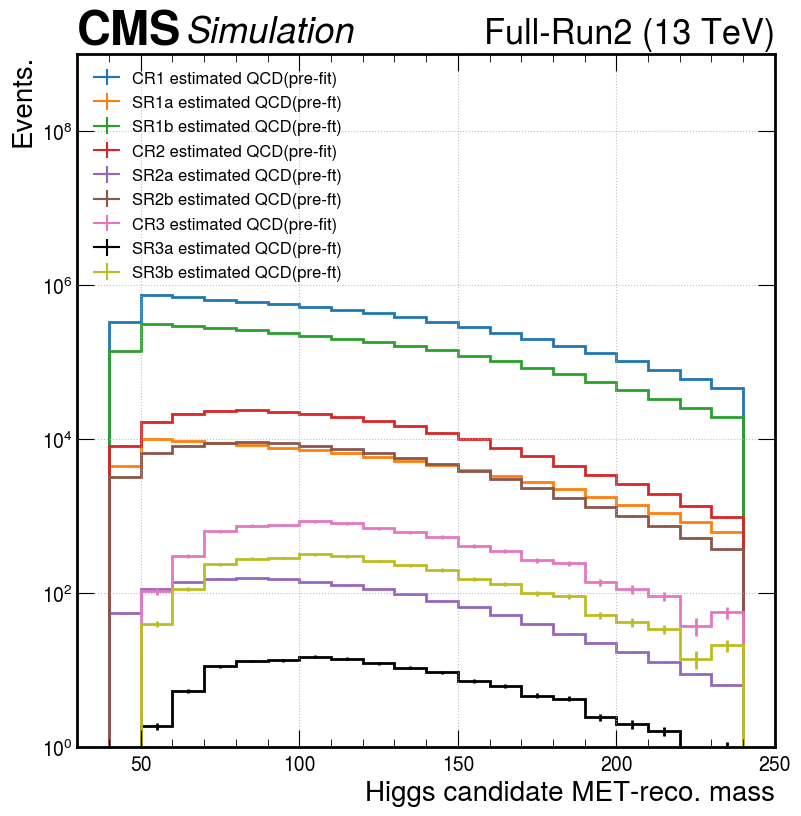

In [9]:
plot_mass_shape_store_blinded(files = files,nbins = 20, x_min=40, x_max=240,suffix = "")

### read the files just stored

In [39]:
def read_root(filename = "/home/pku/zhaoyz/Higgs/MDStudy/SR1a_Shape.root", dir = "QCD", name = "SRa"):
    ''' 
    filename:path/to/root
    dir:"QCD"
    name:region from ["CR1",...]
    '''
    with uproot.open(filename) as file:
        hist = file.get(dir + "/" + name)
        h = np.array(hist.values())
        var = np.array(hist.variances())        
    return h, var
    # here we defined a simple function to read the predicted QCD,etc. shapes from root file directly
    # but you have to be sure with the accuracy about the root file


### Plot variables

In [11]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def prefit_plot(arrays, weight, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = False, blindMC = False, nametext = ""):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    if blind:
        mask = np.logical_or(arrays["data"] <= 80, arrays["data"] >= 160)
        arrays["data"] = arrays["data"][mask]
        if blindMC:
            maskQCD = np.logical_or(arrays["QCD"] <= 80, arrays["QCD"] >= 160)
            maskTop = np.logical_or(arrays["Top"] <= 80, arrays["Top"] >= 160)
            maskWJets = np.logical_or(arrays["WJets"] <= 80, arrays["WJets"] >= 160)
            maskRest = np.logical_or(arrays["Rest"] <= 80, arrays["Rest"] >= 160)
            maskTotalSignal = np.logical_or(arrays["TotalSignal"] <= 80, arrays["TotalSignal"] >= 160)
            maskggF = np.logical_or(arrays["ggF"] <= 80, arrays["ggF"] >= 160)
            maskVH = np.logical_or(arrays["VH"] <= 80, arrays["VH"] >= 160)
            maskttH = np.logical_or(arrays["ttH"] <= 80, arrays["ttH"] >= 160)
            maskVBF = np.logical_or(arrays["VBF"] <= 80, arrays["VBF"] >= 160)
            
            arrays["QCD"] = arrays["QCD"][maskQCD]
            arrays["Top"] = arrays["Top"][maskTop]
            arrays["WJets"] = arrays["WJets"][maskWJets]
            arrays["Rest"] = arrays["Rest"][maskRest]
            arrays["TotalSignal"] = arrays["TotalSignal"][maskTotalSignal]
            arrays["ggF"] = arrays["ggF"][maskggF]
            arrays["VH"] = arrays["VH"][maskVH]
            arrays["ttH"] = arrays["ttH"][maskttH]
            arrays["VBF"] = arrays["VBF"][maskVBF]
            
            weight["QCD"] = weight["QCD"][maskQCD]
            weight["Top"] = weight["Top"][maskTop]
            weight["WJets"] = weight["WJets"][maskWJets]
            weight["Rest"] = weight["Rest"][maskRest]
            weight["TotalSignal"] = weight["TotalSignal"][maskTotalSignal]
            weight["ggF"] = weight["ggF"][maskggF]
            weight["VH"] = weight["VH"][maskVH]
            weight["ttH"] = weight["ttH"][maskttH]
            weight["VBF"] = weight["VBF"][maskVBF]    
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()    
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","Top","WJets","Rest"]
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        # here the var are just usual standard variance
        if k in BKG: 
            if k == "QCD":    # read from root  
                stacked['h'][k] , stacked['var'][k]  = read_root(filename = "./root/perfit_QCD.root", dir = "QCD", name = region)
            else:             # other background
                stacked['h'][k] = h
                stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black',"ggF":"pink","VH":"blue","ttH":"yellow","VBF":"aqua"}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","Top","QCD"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c","#d62728"]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list, yerr = err_list, histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        bkg_err = np.sum(err_list ,  axis=0)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001);
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    for (k,h) in individual['h'].items():
        if k=='data': #data
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
        else:  # signal
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(bkg_h + 1)
            hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            if k == "TotalSignal":
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal cut =",best_lower, best_upper, best_s_sqrt_b) # todo
    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.2)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region + " " + othertext + " blinded",fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region + othertext + " Data/MC = " + str(round(data_mc_ratio,3)),fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=13)
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/{year}_{plot_name}{suffix}_{region}{othertext}_{nametext}.pdf", bbox_inches='tight')
    plt.show()

In [13]:
CUT = {        
        "SR1a" : {k: ( (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files},
        "SR1b" : {k: ( (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        "SR2a" : {k: ( (files[k]["DPhi"] < 0.8)     & (files[k]["a_HWW_V2"] > 0.975)  & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        "SR2b" : {k: ( (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        "SR3a" : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "SR3b" : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["a_HWW_V2"] > 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "CR1"  : {k: ( (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        "CR2"  : {k: ( (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},       
        "CR3"  : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["a_HWW_V2"] > 0.6) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
    }

In [ ]:
CUT_BLINDED = {
        "SR1a_blinded" : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files},
        "SR1b_blinded" : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        "SR2a_blinded" : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["DPhi"] < 0.8)     & (files[k]["a_HWW_V2"] > 0.975)  & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        "SR2b_blinded" : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        "SR3a_blinded" : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "SR3b_blinded" : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["a_HWW_V2"] > 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "CR1_blinded"  : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        "CR2_blinded"  : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},       
        "CR3_blinded"  : {k: ( ((files[k]["MH_Reco"] <= 80) | (files[k]["MH_Reco"] >= 160)) & (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["a_HWW_V2"] > 0.6) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
}

In [15]:
def prefit_runPlots(region = "PS", events = files,othertext = "", blind = True):
    weight={k: events[k][CUT[region][k]]["weight"] for k in events}   
    prefit_plot(arrays = {k: events[k][CUT[region][k]]["MH_Reco"] for k in events},  region = region, othertext = othertext, plot_name='METReco', x_name=r'$jet_{a}:MET Reco. Mass$', x_max=240, x_min=40, bins=20, weight =weight, year="Full-Run2",blind = blind, blindMC = False)

Should scale signal *  1159.1320761952727
Optimal cut = 6 11 0.32611438062239645


/tmp/ipykernel_2498319/195236659.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


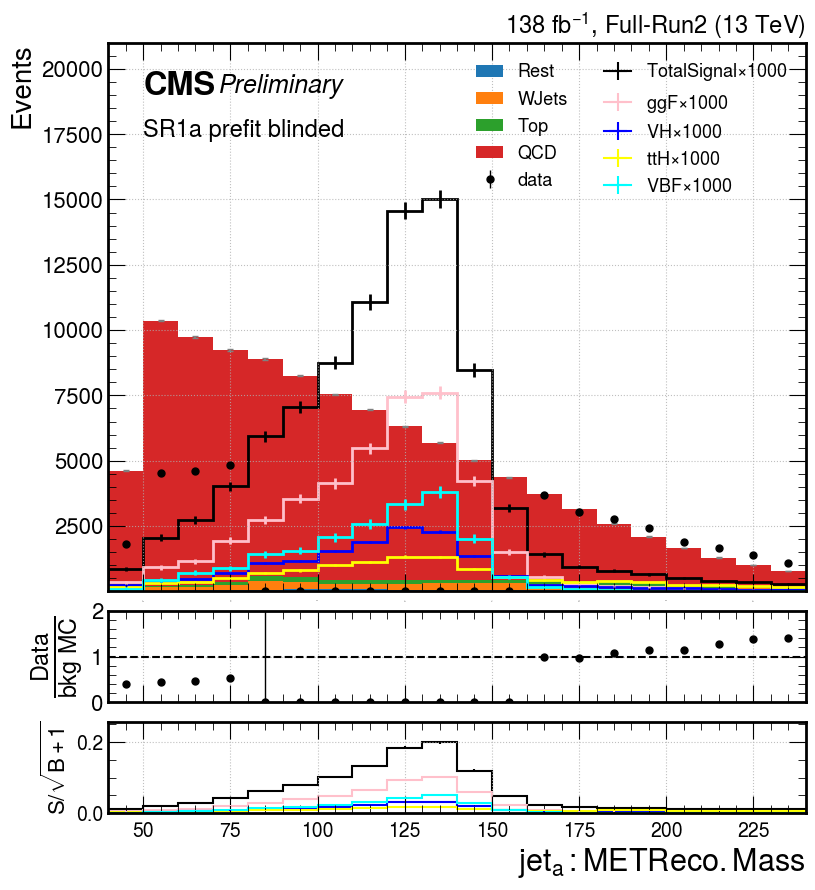

Should scale signal *  11504.292108803664
Optimal cut = 6 12 0.17343983574615968


/tmp/ipykernel_2498319/195236659.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


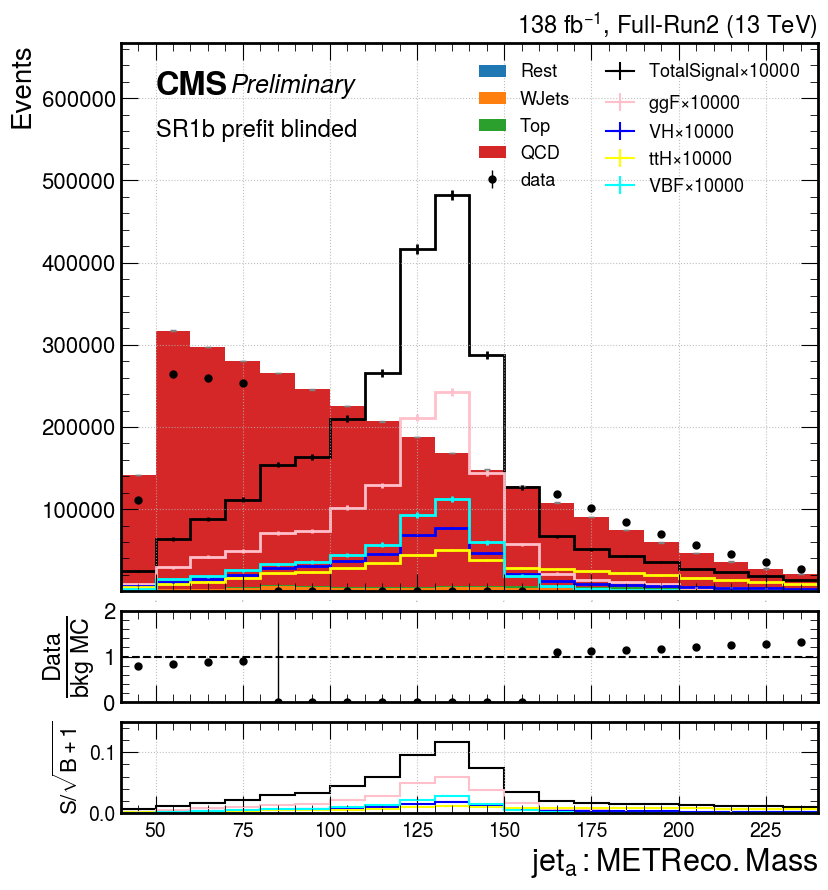

Should scale signal *  38203.42257174624
Optimal cut = 4 20 0.07373290878321552


/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


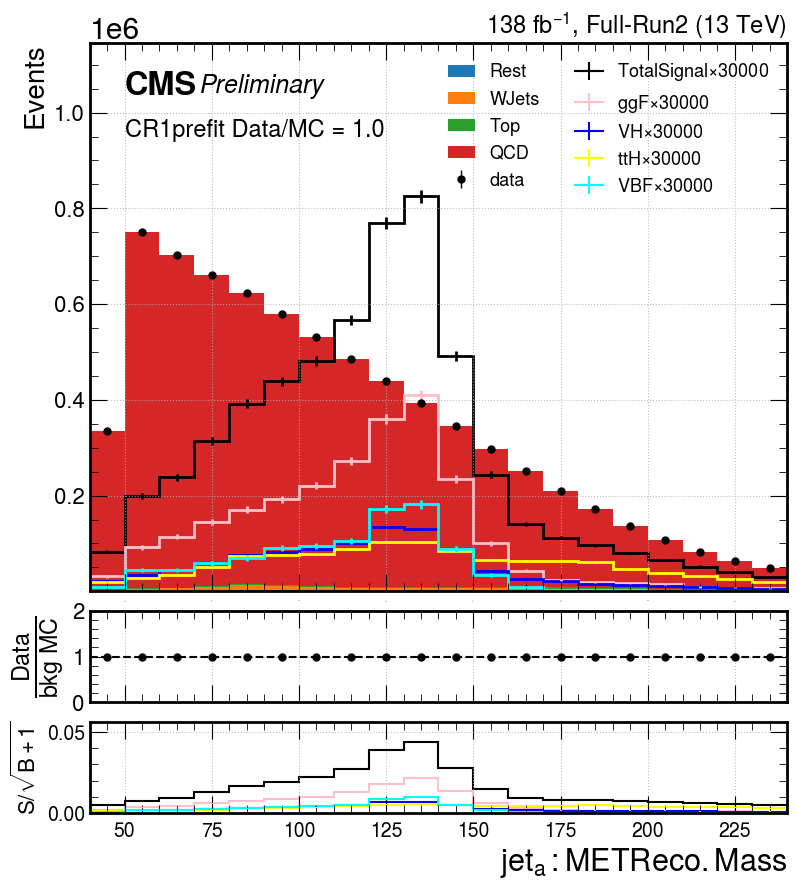

/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2498319/195236659.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498

Should scale signal *  139.92142275220212
Optimal cut = 4 14 0.36457216880367194


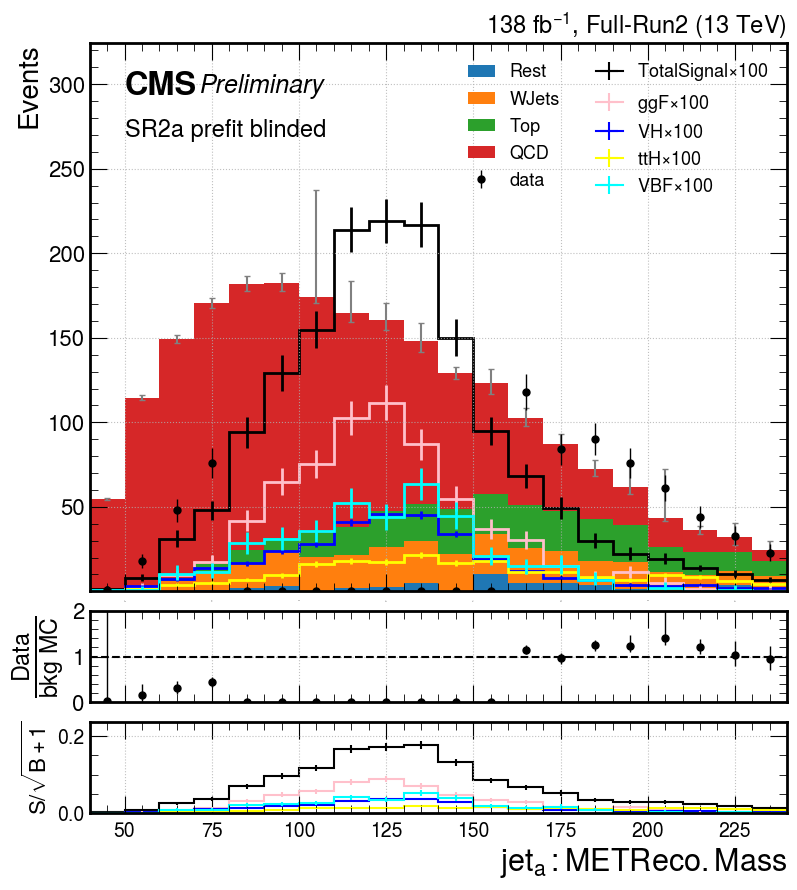

Should scale signal *  3444.987640623713
Optimal cut = 5 20 0.09818601144672219


/tmp/ipykernel_2498319/195236659.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


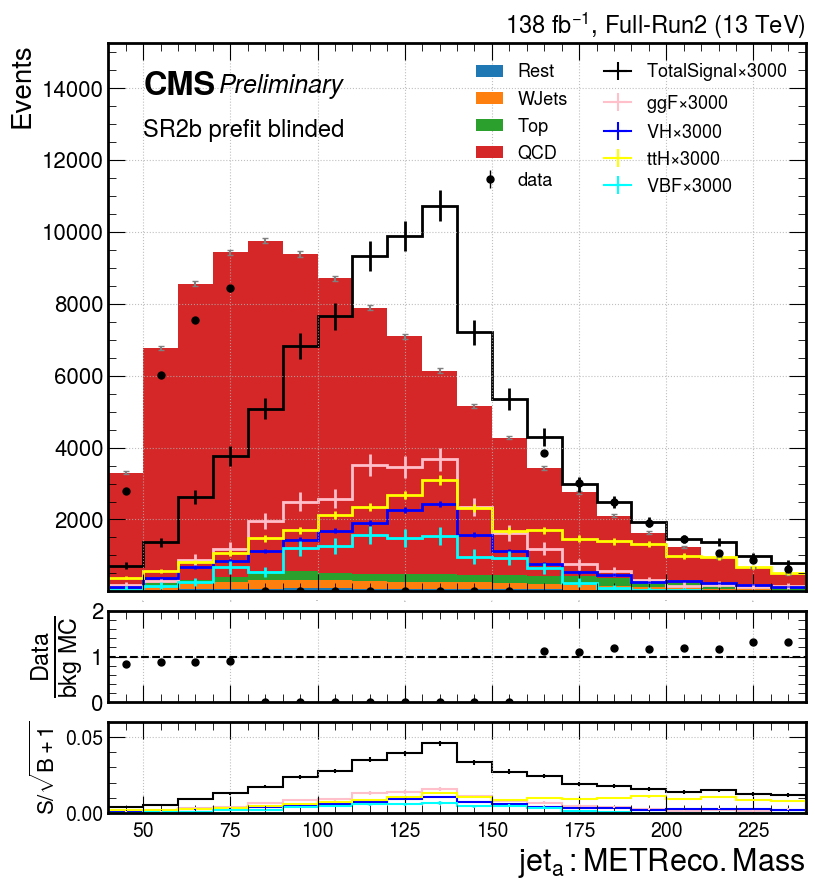

Should scale signal *  12586.398484075913
Optimal cut = 4 20 0.04116018318483422


/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


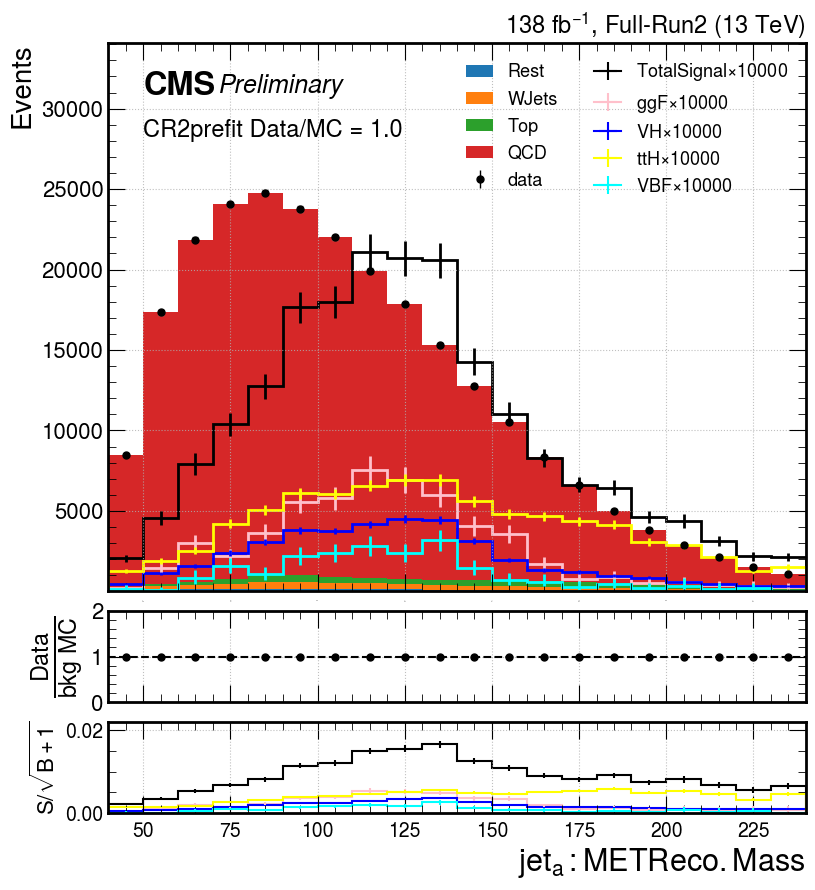

/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2498319/195236659.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_2498319/195236659.py:106: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498

Should scale signal *  57.005247022467735
Optimal cut = 1 11 0.48977547450865816


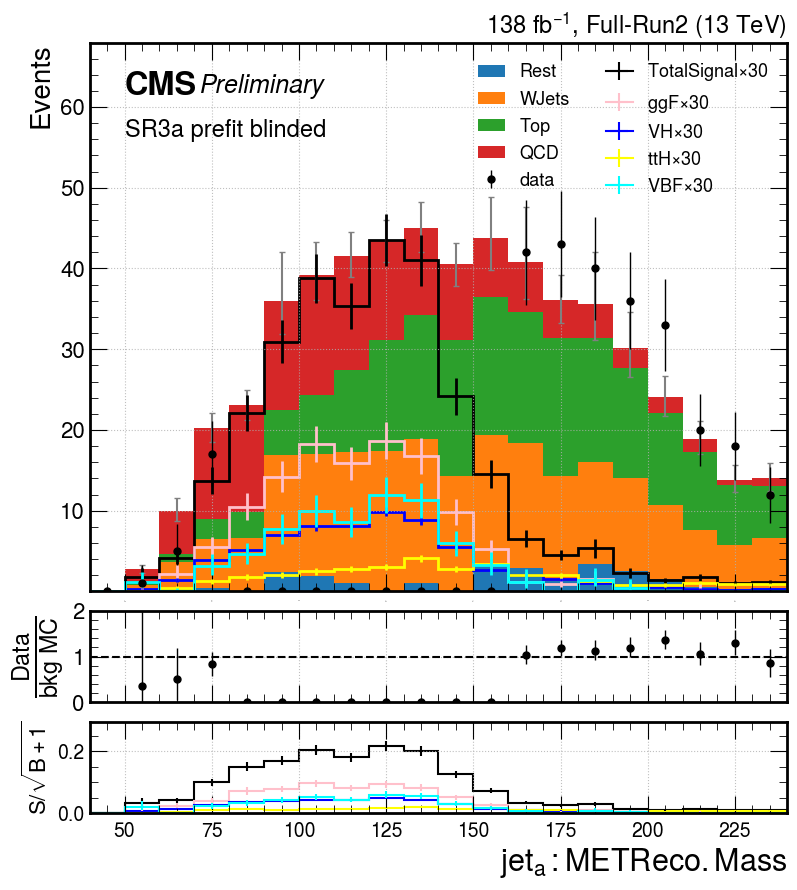

/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2498319/195236659.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_2498319/195236659.py:106: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498

Should scale signal *  385.9296435638134
Optimal cut = 2 20 0.17618772593707765


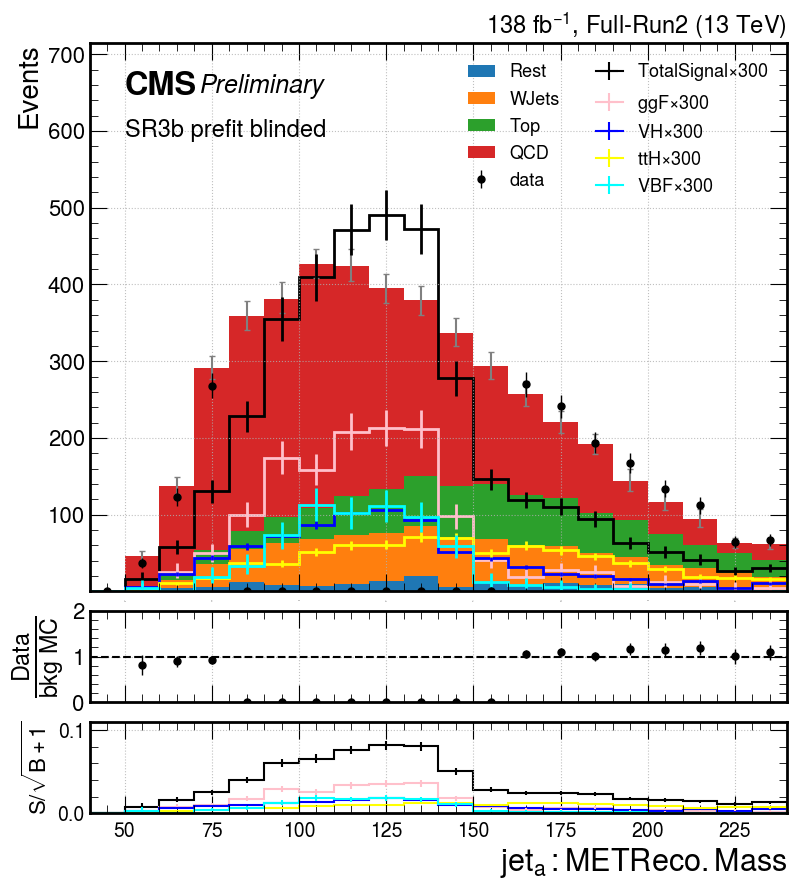

/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498319/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_2498319/195236659.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_2498319/195236659.py:106: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_2498319/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_2498319/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_2498

Should scale signal *  1569.3417080975908
Optimal cut = 3 20 0.0625589540005484


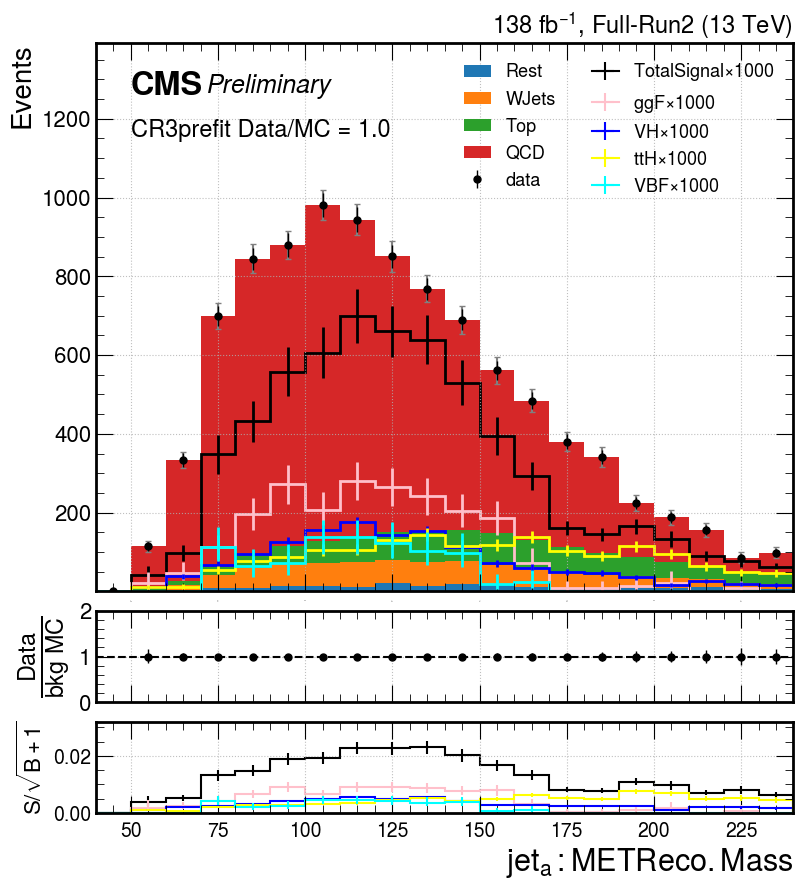

In [16]:
prefit_runPlots(region = "SR1a", othertext = "prefit")
prefit_runPlots(region = "SR1b", othertext = "prefit")
prefit_runPlots(region = "CR1",  othertext = "prefit", blind = False)
prefit_runPlots(region = "SR2a", othertext = "prefit")
prefit_runPlots(region = "SR2b", othertext = "prefit")
prefit_runPlots(region = "CR2",  othertext = "prefit", blind = False)
prefit_runPlots(region = "SR3a", othertext = "prefit")
prefit_runPlots(region = "SR3b", othertext = "prefit")
prefit_runPlots(region = "CR3",  othertext = "prefit", blind = False)

### Define observable object variables

In [16]:
@dataclass
class ShapeVar:
    """Class to store attributes of a variable to make a histogram of.

    Args:
        var (str): variable name
        label (str): variable label
        bins (List[int]): bins
        reg (bool, optional): Use a regular axis or variable binning. Defaults to True.
        blind_window (List[int], optional): if blinding, set min and max values to set 0. Defaults to None.
        significance_dir (str, optional): if plotting significance, which direction to plot it in.
          See more in plotting.py:ratioHistPlot(). Options are ["left", "right", "bin"]. Defaults to "right".
    """

    var: str = None
    label: str = None
    bins: List[int] = None
    reg: bool = True #regular axis
    blind_window: List[int] = None
    significance_dir: str = "right"

    def __post_init__(self):
        # create axis used for histogramming
        if self.reg:
            self.axis = hist2.axis.Regular(*self.bins, name=self.var, label=self.label)
        else:
            self.axis = hist2.axis.Variable(self.bins, name=self.var, label=self.label)
def blindBins(h: hist2.Hist, blind_region: List, blind_sample: str = None, axis=0):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_sample`` specified, only blind that sample, else blinds all.
    """
    if axis > 0:
        raise Exception("not implemented > 1D blinding yet")

    bins = h.axes[axis + 1].edges
    lv = int(np.searchsorted(bins, blind_region[0], "right"))
    rv = int(np.searchsorted(bins, blind_region[1], "left") + 1)

    if blind_sample is not None:
        data_key_index = np.where(np.array(list(h.axes[0])) == blind_sample)[0][0]
        h.view(flow=True)[data_key_index][lv:rv].value = 0
        h.view(flow=True)[data_key_index][lv:rv].variance = 0
    else:
        h.view(flow=True)[:, lv:rv].value = 0
        h.view(flow=True)[:, lv:rv].variance = 0       
shape_vars = [
    ShapeVar(
        "MH_Reco",
        r"Higgs candidate MET recovery mass [GeV]",
        [20, 40, 240],
        reg=True,
        blind_window=[80, 160],
    )
]


### Save hist templates to pkl files

In [17]:

def save_pkl(files, template_file = "./templates/hists_templates_run2.pkl"):
    regions = ["SR1a","SR1b","CR1","SR2a","SR2b","CR2","SR3a","SR3b","CR3"] #signal regions or control regions
    # samples = list(['data','QCD','Top','WJets','Rest','TotalSignal','ggF','VH','ttH','VBF']) 
    samples = list(['data','QCD','Top','WJets','Rest','ggF','VH','ttH','VBF']) # ignore the combined "TotalSignal" for a test
    weights = [] #uncertainties to be added 
    templates = {}
    for region in regions:
        templates[region] = hist2.Hist(
            hist2.axis.StrCategory(samples, name="Sample"),
            # hist2.axis.StrCategory([], name="systematic", growth=True),
            *[shape_var.axis for shape_var in shape_vars],
            storage="weight",
            ) #initialize a hist object
        for sample in samples:
            data = files[sample][CUT[region][sample]] if ("blinded" not in region) else files[sample][CUT_BLINDED[region][sample]]
            templates[region].fill(
                Sample=sample,
                # systematic="nominal",
                MH_Reco=data["MH_Reco"],
                weight=data["weight"],
            )
            if sample == "data": 
                if (region.endswith("a") or region.endswith("b")):
                    # blind signal mass windows in pass region in data
                    print("blind data of ",region)
                    for i, shape_var in enumerate(shape_vars):
                        if shape_var.blind_window is not None:
                            blindBins(templates[region], shape_var.blind_window, "data", axis=i) 
            for weight in weights:
                pass #uncertainties to be added
        print("done fill template ",region)        
    #Creates blinded copies of each region's templates and saves a pickle of the templates
    blind_window = shape_vars[0].blind_window
    for label, template in list(templates.items()):
        blinded_template = deepcopy(template)
        blindBins(blinded_template, blind_window)
        templates[f"{label}Blinded"] = blinded_template
    with open(template_file, "wb") as fp:
        pkl.dump(templates, fp) # dump the templates of each region in a pkl file
        print("Saved templates to", template_file)

In [18]:
save_pkl(files = files)


blind data of  SR1a
done fill template  SR1a
blind data of  SR1b
done fill template  SR1b
done fill template  CR1
blind data of  SR2a
done fill template  SR2a
blind data of  SR2b
done fill template  SR2b
done fill template  CR2
blind data of  SR3a
done fill template  SR3a
blind data of  SR3b
done fill template  SR3b
done fill template  CR3
Saved templates to ./templates/hists_templates_run2.pkl


### some test about the output templates

In [27]:
with open("/ospool/cms-user/yuzhe/BoostedHWW/prediction/HHbbVV/src/HHbbVV/postprocessing/templates/23May13Nonres/2017_templates.pkl","rb") as f:
    hists_template = pkl.load(f)
# hists_template["pass"]["QCD",:]  
# hists_template["pass"]["QCD",:].sum().value
hists_template["pass"]["QCD",:]

Hist(Regular(20, 50, 250, name='bbFatJetParticleNetMass', label='$m^{bb}_{Reg}$ (GeV)'), storage=Weight()) # Sum: WeightedSum(value=39.3871, variance=137.026)

In [28]:
with open("./templates/hists_templates_run2.pkl","rb") as f:
    hists_template = pkl.load(f)
# hists_template["pass"]["QCD",:]  
# hists_template["pass"]["QCD",:].sum().value
hists_template["SR1a"]["QCD",:]

Hist(Regular(20, 40, 240, name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'), storage=Weight()) # Sum: WeightedSum(value=73098.2, variance=429842) (WeightedSum(value=76178.2, variance=436513) with flow)

In [18]:
hists_template["passBlinded"]

Hist(
  StrCategory(['HHbbVV', 'QCD', 'TT', 'ST', 'V+Jets', 'Diboson', 'Data', 'HHbbVV_txbb_down', 'HHbbVV_pileup_down', 'QCD_pileup_down', 'TT_pileup_down', 'ST_pileup_down', 'V+Jets_pileup_down', 'Diboson_pileup_down', 'HHbbVV_PDFalphaS_down', 'HHbbVV_ISRPartonShower_down', 'V+Jets_ISRPartonShower_down', 'HHbbVV_FSRPartonShower_down', 'V+Jets_FSRPartonShower_down', 'HHbbVV_L1EcalPrefiring_down', 'QCD_L1EcalPrefiring_down', 'TT_L1EcalPrefiring_down', 'ST_L1EcalPrefiring_down', 'V+Jets_L1EcalPrefiring_down', 'Diboson_L1EcalPrefiring_down', 'HHbbVV_txbb_up', 'HHbbVV_pileup_up', 'QCD_pileup_up', 'TT_pileup_up', 'ST_pileup_up', 'V+Jets_pileup_up', 'Diboson_pileup_up', 'HHbbVV_PDFalphaS_up', 'HHbbVV_ISRPartonShower_up', 'V+Jets_ISRPartonShower_up', 'HHbbVV_FSRPartonShower_up', 'V+Jets_FSRPartonShower_up', 'HHbbVV_L1EcalPrefiring_up', 'QCD_L1EcalPrefiring_up', 'TT_L1EcalPrefiring_up', 'ST_L1EcalPrefiring_up', 'V+Jets_L1EcalPrefiring_up', 'Diboson_L1EcalPrefiring_up'], name='Sample'),
  Regular(20, 50, 250, name='bbFatJetParticleNetMass', label='$m^{bb}_{Reg}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=461.893, variance=1092.32)

In [19]:
sample_template = hists_template["pass"]["QCD", :]
err = sample_template.variances()
err

array([13.28524337,  1.63602478, 35.13665137, 24.8476674 , 17.38421633,
        0.23765398,  0.        ,  0.        ,  0.        , 14.19115751,
       12.12285395,  0.        ,  0.        , 18.0306419 ,  0.        ,
        0.        ,  0.        ,  0.15379214,  0.        ,  0.        ])

In [5]:
for i , axis in enumerate(hists_template["pass"].axes[1:]):
    print(i, axis)

0 Regular(20, 50, 250, name='bbFatJetParticleNetMass', label='$m^{bb}_{Reg}$ (GeV)')


In [22]:
with open("./templates/hists_templates_non_blinded.pkl", "rb") as f:
    hists_templates3 = pkl.load(f)
# hists_templates2["SR2b"]["QCD","nominal",:]
# hists_templates3["SR2a"]["WJets",:].variances()
# hists_templates3["SR2a"]["WJets",:].values(flow=True)
# hists[region][sample,:].variances()
# hists_templates3["SR3a"]["QCD",:].sum().value
# hists_templates3["SR3a_blinded"].axes[1:].edges
hists_templates3["SR1a"]["data",:]


Hist(Regular(20, 40, 240, name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'), storage=Weight()) # Sum: WeightedSum(value=70596, variance=70596) (WeightedSum(value=74053, variance=74053) with flow)

In [18]:
def get_template(h, sample):
    ''' 
    histogram h Hist, with axes:["samples","systematic","MH_Reco"]
    sample is sample name in ["QCD",...,"data"]
    '''
    mass_axis = 1 #axis index
    massbins = h.axes[mass_axis].edges
    return (h[sample, :].values(), massbins, "MH_Reco")
a = get_template(hists_templates3["SR3a"],"QCD")
a

(array([ 0.        ,  2.61734887,  2.40244829, 13.38662184,  0.        ,
        12.94938391,  7.15780488, 11.0105996 , 18.07070539,  0.        ,
         7.82469779,  0.89133593,  1.93871653,  2.80038463,  3.449436  ,
         0.53863144,  0.2711149 ,  0.3287236 ,  0.        ,  2.0529086 ]),
 array([ 40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.,
        150., 160., 170., 180., 190., 200., 210., 220., 230., 240.]),
 'MH_Reco')

In [11]:
print(np.linspace(40, 240, 21))

[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180. 190. 200. 210. 220. 230. 240.]


In [22]:
region = "SR1a_blinded"
region_noblinded = region.split("Blinded")[0]
region_noblinded

'SR1a_blinded'

In [23]:
with open("/ospool/cms-user/yuzhe/BoostedHWW/templates/hists_templates.pkl", "rb") as f:
    hists_templates2 = pkl.load(f)
# hists_templates2["SR2b"]["QCD","nominal",:]
hists_templates2["SR1a"]


Hist(
  StrCategory(['data', 'QCD', 'Top', 'WJets', 'Rest', 'TotalSignal', 'ggF', 'VH', 'ttH', 'VBF'], growth=True, name='samples'),
  StrCategory(['nominal'], growth=True, name='systematic'),
  Variable([40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240], name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'),
  storage=Double()) # Sum: 180718.16633693522 (187720.00093823727 with flow)

In [24]:
s = hists_templates2["SR2b"]["QCD","nominal",:].values()
s

array([3203.02070336, 6572.62066135, 8285.4921792 , 9054.65869084,
       9238.41630798, 8848.39851649, 8216.47968383, 7426.8752504 ,
       6636.35788367, 5675.92702307, 4705.99830901, 3851.05757845,
       3016.61454661, 2346.25346119, 1746.21552669, 1329.19273989,
       1006.60297794,  747.02345128,  521.59205541, 1340.4213692 ])

In [25]:
s = hists_templates2["SR2b"]["WJets","nominal",:].variances()
s

In [26]:
s = hists_templates2["SR2b"]["QCD","nominal",:].values()
values_nominal = np.maximum(s, 0.0)
values_nominal

array([3203.02070336, 6572.62066135, 8285.4921792 , 9054.65869084,
       9238.41630798, 8848.39851649, 8216.47968383, 7426.8752504 ,
       6636.35788367, 5675.92702307, 4705.99830901, 3851.05757845,
       3016.61454661, 2346.25346119, 1746.21552669, 1329.19273989,
       1006.60297794,  747.02345128,  521.59205541, 1340.4213692 ])

In [28]:
# values_nominal = np.maximum(s.values(), 0.0)
# values_nominal

In [29]:
for i, axis in enumerate(hists_templates2["SR1a"].axes[2:]):
    print(i, axis) 

0 Variable([40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240], name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]')


In [ ]:
region = "SR1a"
region2 = "CR1"
pass_region = (region.endswith("a") or region.endswith("b"))
pass_region

True

In [ ]:
hists_templates["SR3a"].project("MH_Reco") #N.B. here data is also added

Hist(Variable([40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240], name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'), storage=Double()) # Sum: 1284.0328060902589 (1391.2353290328374 with flow)

In [ ]:
hists_templates["SR3a"].axes[2].edges #access the axes through index

array([ 40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.,
       150., 160., 170., 180., 190., 200., 210., 220., 230., 240.])

In [ ]:
massbins = hists_templates["SR1a"].axes[2].edges
masses = (massbins[:-1] + 0.5 * np.diff(massbins))
mass_scaled = (masses - masses[0]) / (masses[-1] - masses[0])
mass_scaled

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [ ]:
hists_templates["SR3a"][{"samples": "QCD", "systematic": "nominal"}].values() #another way to access the value

array([ 0.        ,  1.85686087,  5.33073188, 11.09815239, 13.09203295,
       13.29814235, 14.8429755 , 14.00588169, 12.18572567, 10.69694686,
        9.2954443 ,  7.19961509,  6.13408838,  4.63281281,  4.22245801,
        2.41129675,  1.95302421,  1.59153709,  0.65292898,  2.98913682])

In [ ]:
with open("/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedhiggs/combine/templates/v1/hists_templates_2017_ele.pkl", "rb") as f:
    hists_templates2 = pkl.load(f)
# hists_templates2["SR2b"]["QCD","nominal",:]
hists_templates2

{'pass': Hist(
   StrCategory(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'ggF', 'WZQQ', 'Data', 'QCD', 'Diboson', 'ttH'], growth=True, name='samples'),
   StrCategory(['nominal', 'weight_ele_pileupUp', 'weight_ele_pileupDown', 'weight_ele_isolation_electronUp', 'weight_ele_isolation_electronDown', 'weight_ele_id_electronUp', 'weight_ele_id_electronDown', 'weight_ele_L1PrefiringUp', 'weight_ele_L1PrefiringDown', 'weight_ele_trigger_electronUp', 'weight_ele_trigger_electronDown', 'weight_ele_reco_electronUp', 'weight_ele_reco_electronDown', 'weight_ele_aS_weightUp', 'weight_ele_aS_weightDown', 'weight_ele_UEPS_FSRUp', 'weight_ele_UEPS_FSRDown', 'weight_ele_UEPS_ISRUp', 'weight_ele_UEPS_ISRDown', 'weight_ele_PDF_weightUp', 'weight_ele_PDF_weightDown', 'weight_ele_PDFaS_weightUp', 'weight_ele_PDFaS_weightDown', 'weight_ele_scalevar_3ptUp', 'weight_ele_scalevar_3ptDown', 'weight_ele_scalevar_7ptUp', 'weight_ele_scalevar_7ptDown', 'weight_ele_d1K_NLOUp', 'weight_ele_d1K_NLODow

In [ ]:
regions = {
        "CR1" :{"SRa": "SR1a","SRb":"SR1b"},
        "CR2" :{"SRa": "SR2a","SRb":"SR2b"},
        "CR3" :{"SRa": "SR3a","SRb":"SR3b"},
        }

regions_blinded = { key_fail + "_blinded": {key_pass + "_blinded" : key_pass_ab + "_blinded" for key_pass , key_pass_ab in key_pass_dict.items()}  for key_fail , key_pass_dict in regions.items()}
regions_blinded.keys()

dict_keys(['CR1_blinded', 'CR2_blinded', 'CR3_blinded'])

In [2]:
region = "SR1a_blinded"
pass_region = ("a_" in region)
pass_region

True

In [29]:
region = "SR1aBlinded"
region_noblinded = region.split("Blinded")[0]
region_noblinded

'SR1a'

### Some other implementation(not done)

### plot postfit results

In [41]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def postfit_plot(arrays, weight, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = False, blindMC = False, nametext = "",postfit_files = ""):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    if blind:
        mask = np.logical_or(arrays["data"] <= 80, arrays["data"] >= 160)
        arrays["data"] = arrays["data"][mask]
        if blindMC:
            maskQCD = np.logical_or(arrays["QCD"] <= 80, arrays["QCD"] >= 160)
            maskTop = np.logical_or(arrays["Top"] <= 80, arrays["Top"] >= 160)
            maskWJets = np.logical_or(arrays["WJets"] <= 80, arrays["WJets"] >= 160)
            maskRest = np.logical_or(arrays["Rest"] <= 80, arrays["Rest"] >= 160)
            maskTotalSignal = np.logical_or(arrays["TotalSignal"] <= 80, arrays["TotalSignal"] >= 160)
            maskggF = np.logical_or(arrays["ggF"] <= 80, arrays["ggF"] >= 160)
            maskVH = np.logical_or(arrays["VH"] <= 80, arrays["VH"] >= 160)
            maskttH = np.logical_or(arrays["ttH"] <= 80, arrays["ttH"] >= 160)
            maskVBF = np.logical_or(arrays["VBF"] <= 80, arrays["VBF"] >= 160)
            
            arrays["QCD"] = arrays["QCD"][maskQCD]
            arrays["Top"] = arrays["Top"][maskTop]
            arrays["WJets"] = arrays["WJets"][maskWJets]
            arrays["Rest"] = arrays["Rest"][maskRest]
            arrays["TotalSignal"] = arrays["TotalSignal"][maskTotalSignal]
            arrays["ggF"] = arrays["ggF"][maskggF]
            arrays["VH"] = arrays["VH"][maskVH]
            arrays["ttH"] = arrays["ttH"][maskttH]
            arrays["VBF"] = arrays["VBF"][maskVBF]
            
            weight["QCD"] = weight["QCD"][maskQCD]
            weight["Top"] = weight["Top"][maskTop]
            weight["WJets"] = weight["WJets"][maskWJets]
            weight["Rest"] = weight["Rest"][maskRest]
            weight["TotalSignal"] = weight["TotalSignal"][maskTotalSignal]
            weight["ggF"] = weight["ggF"][maskggF]
            weight["VH"] = weight["VH"][maskVH]
            weight["ttH"] = weight["ttH"][maskttH]
            weight["VBF"] = weight["VBF"][maskVBF]    
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()    
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","Top","WJets","Rest"]
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        # here the var are just usual standard variance
        if k in BKG: 
            if k == "QCD":    # read from root  
                stacked['h'][k] , stacked['var'][k]  = read_root(filename = postfit_files, dir = region + "_postfit", name = "CMS_HWW_boosted_qcd_datadriven")
            else:             # other background
                stacked['h'][k] = h
                stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black',"ggF":"pink","VH":"blue","ttH":"yellow","VBF":"aqua"}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","Top","QCD"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c","#d62728"]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list, yerr = err_list, histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        bkg_err = np.sum(err_list ,  axis=0)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001);
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    for (k,h) in individual['h'].items():
        if k=='data': #data
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
        else:  # signal
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(bkg_h + 1)
            hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            if k == "TotalSignal":
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal cut =",best_lower, best_upper, best_s_sqrt_b) # todo
    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.2)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region + " " + othertext + " blinded",fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region + othertext + " Data/MC = " + str(round(data_mc_ratio,3)),fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=13)
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/{year}_{plot_name}{suffix}_{region}{othertext}_{nametext}.pdf", bbox_inches='tight')
    plt.show()

In [35]:
def postfit_runPlots(region = "PS", events = files,othertext = "", blind = True, postfit_files = ""):
    weight={k: events[k][CUT[region][k]]["weight"] for k in events}   
    postfit_plot(arrays = {k: events[k][CUT[region][k]]["MH_Reco"] for k in events},  region = region, othertext = othertext, plot_name='METReco', x_name=r'$jet_{a}:MET Reco. Mass$', x_max=240, x_min=40, bins=20, weight =weight, year="Full-Run2",blind = blind, blindMC = False,postfit_files = postfit_files)

In [32]:
CUT = {        
        "SR1a" : {k: ( (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files},
        # "SR1b" : {k: ( (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        # "SR2a" : {k: ( (files[k]["DPhi"] < 0.8)     & (files[k]["a_HWW_V2"] > 0.975)  & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        # "SR2b" : {k: ( (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        # "SR3a" : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        # "SR3b" : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["a_HWW_V2"] > 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "CR1"  : {k: ( (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        # "CR2"  : {k: ( (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},       
        # "CR3"  : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["a_HWW_V2"] > 0.6) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
    }

Should scale signal *  717.7244095273736
Optimal cut = 6 11 0.41356097964554184


/tmp/ipykernel_3590271/655230008.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_3590271/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3590271/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


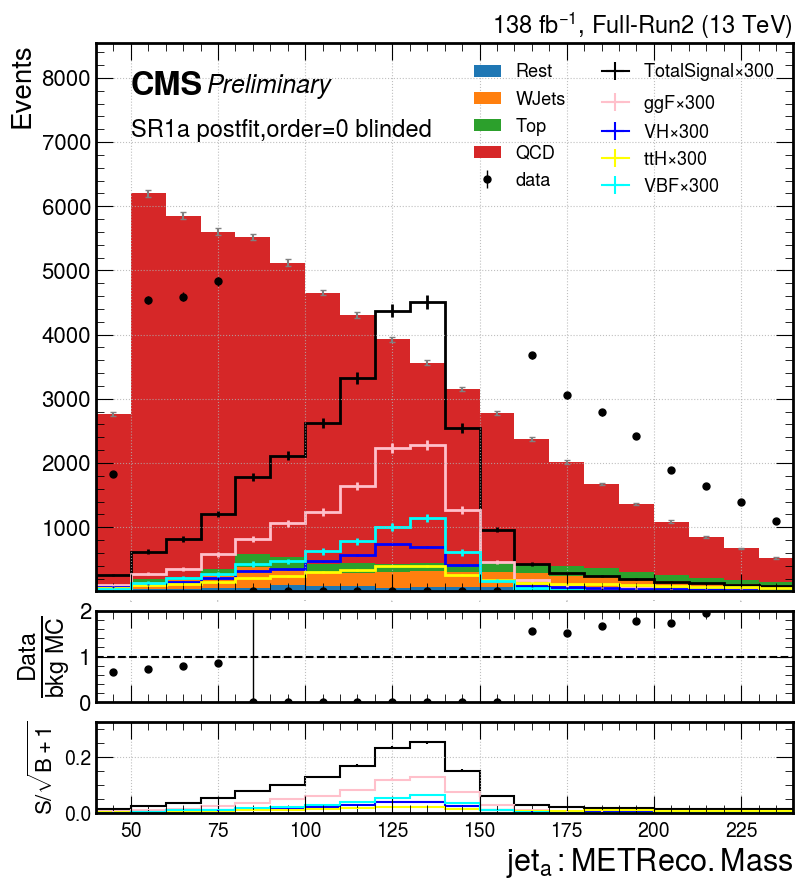

/tmp/ipykernel_3590271/2123724067.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_3590271/2123724067.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3590271/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


Should scale signal *  38096.084484195104
Optimal cut = 4 20 0.07379387079941495


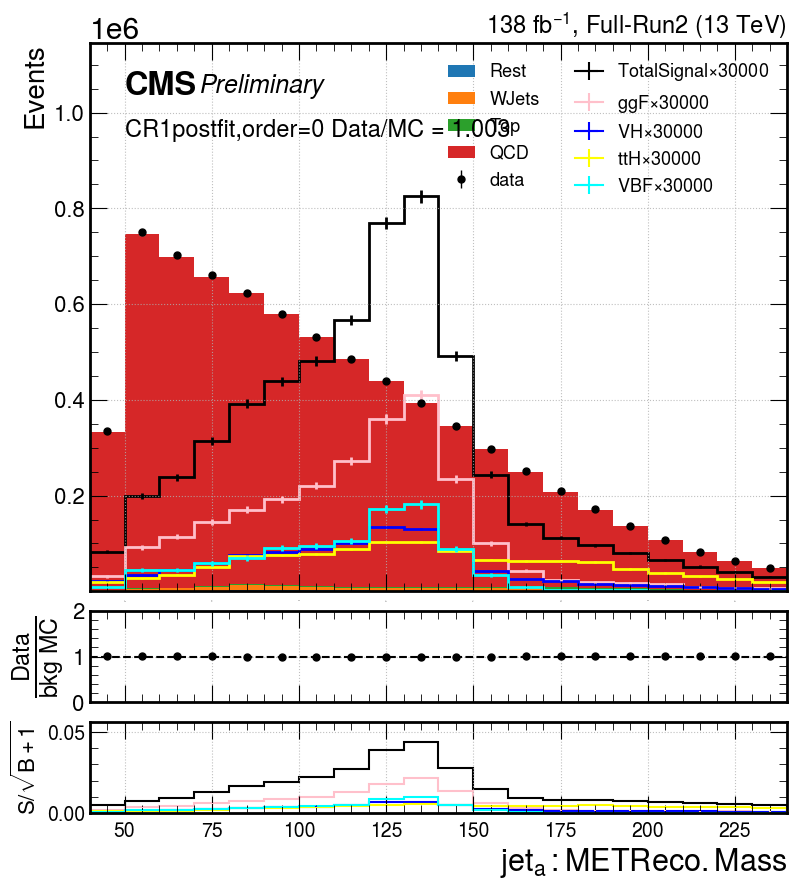

Should scale signal *  823.3614489485129
Optimal cut = 4 11 0.37612957708152966


/tmp/ipykernel_3590271/655230008.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_3590271/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3590271/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


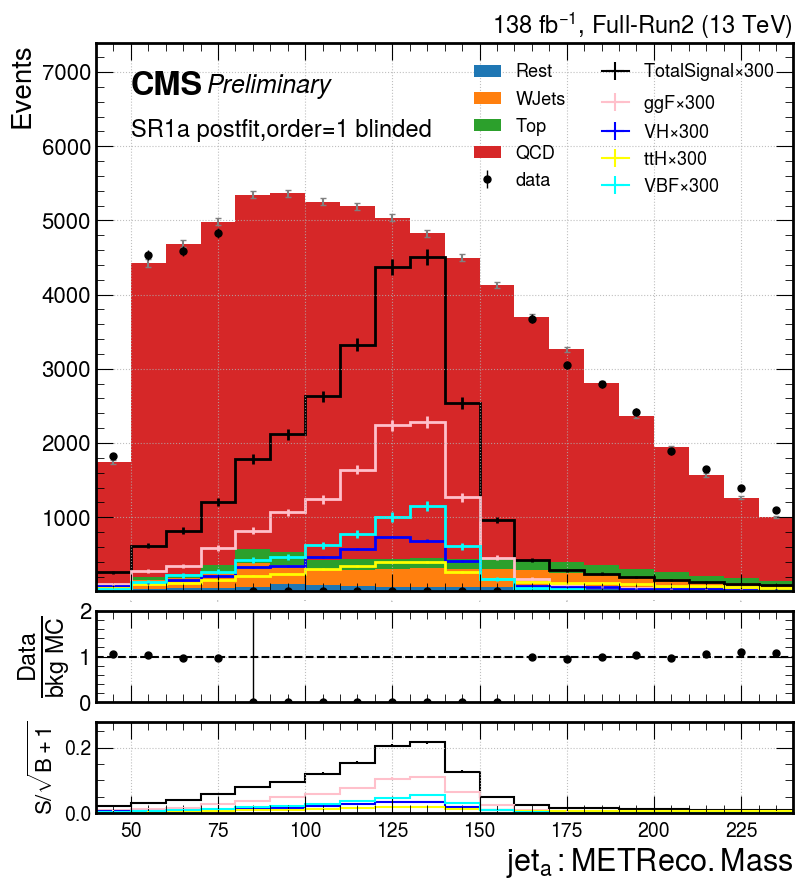

/tmp/ipykernel_3590271/2123724067.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_3590271/2123724067.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3590271/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


Should scale signal *  38202.96425145918
Optimal cut = 4 20 0.0737329255691587


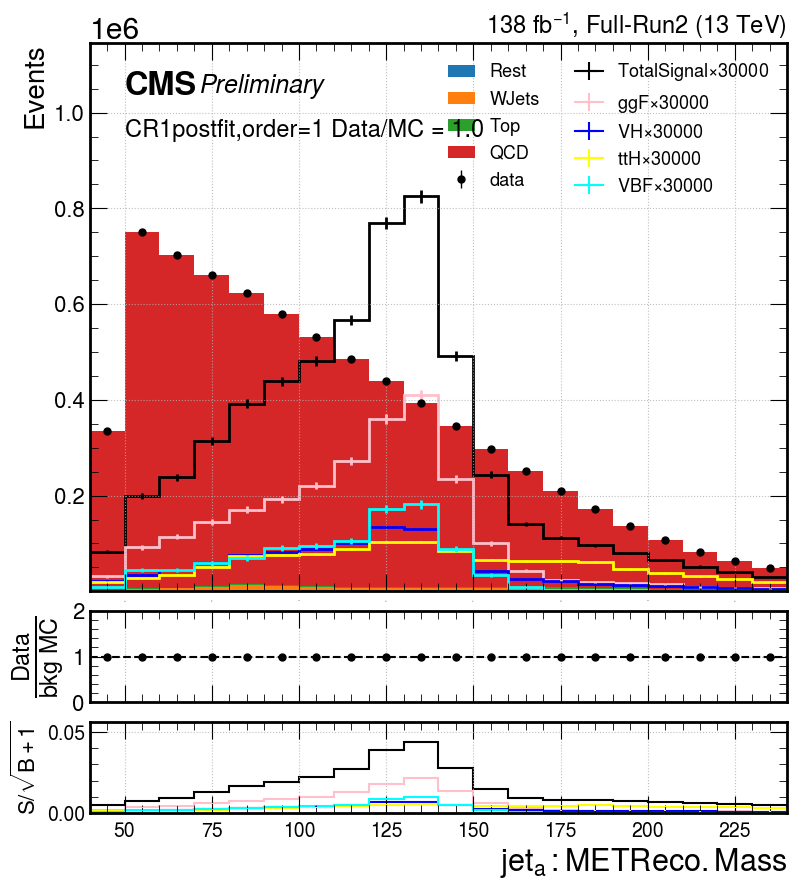

Should scale signal *  797.4371795487566
Optimal cut = 4 11 0.38809197062101874


/tmp/ipykernel_3590271/655230008.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_3590271/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3590271/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


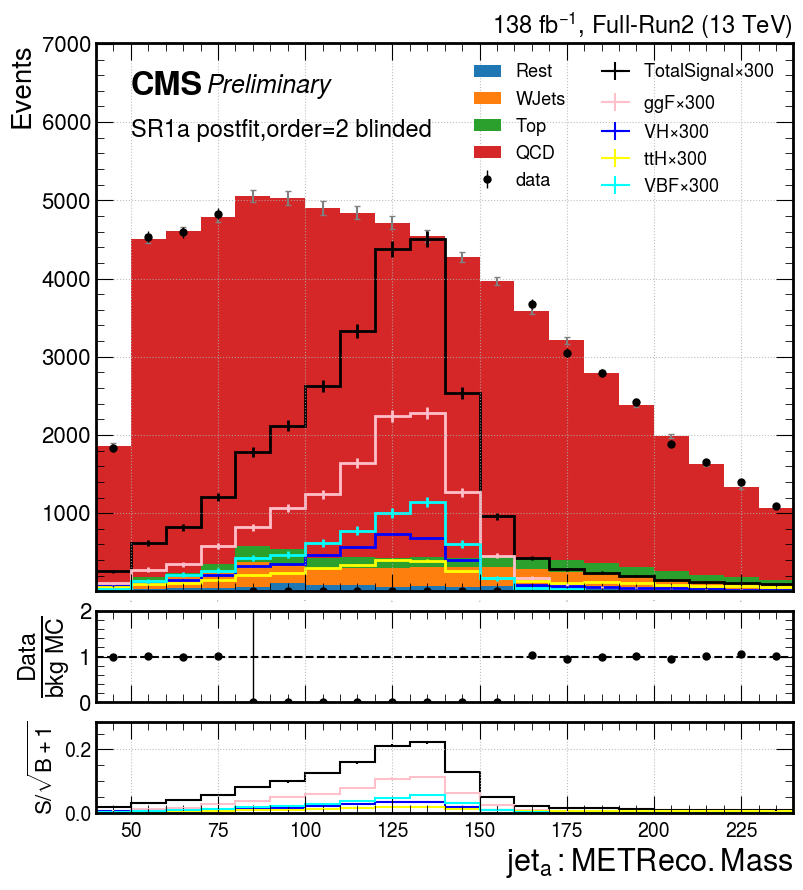

/tmp/ipykernel_3590271/2123724067.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_3590271/2123724067.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3590271/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


Should scale signal *  38203.35301609793
Optimal cut = 4 20 0.07373314179750695


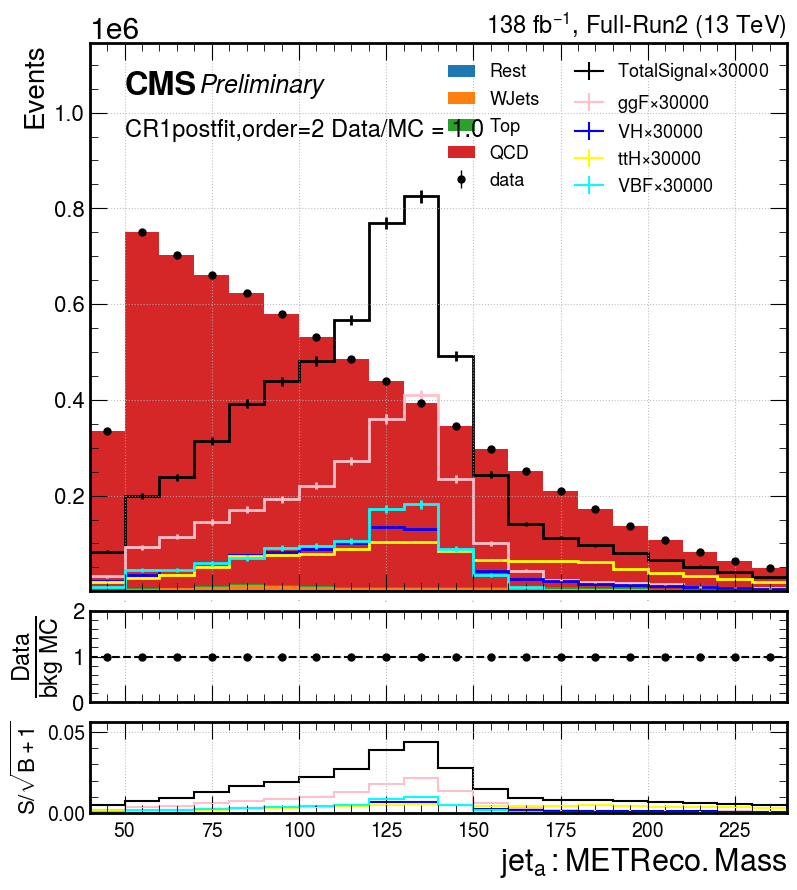

Should scale signal *  797.0037299188
Optimal cut = 4 11 0.3880805255615287


/tmp/ipykernel_3590271/655230008.py:105: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_3590271/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3590271/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


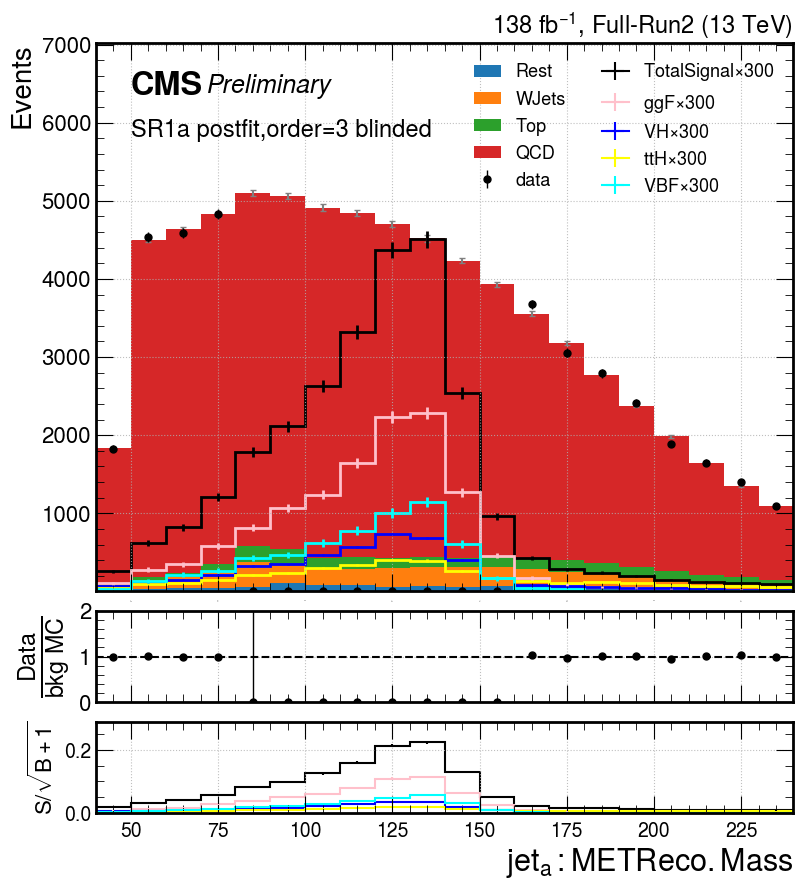

/tmp/ipykernel_3590271/2123724067.py:34: RuntimeWarning: divide by zero encountered in divide
  number = h**2 / var
/tmp/ipykernel_3590271/2123724067.py:51: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:52: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3590271/2123724067.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3590271/2123724067.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


Should scale signal *  38203.36344773174
Optimal cut = 4 20 0.07373291399148871


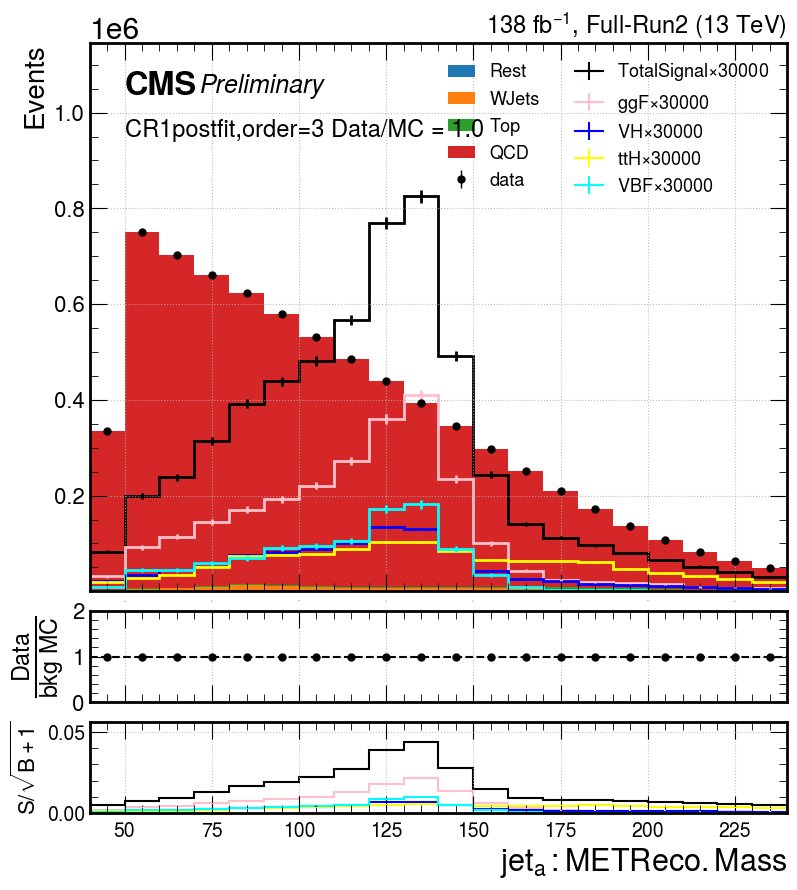

In [44]:
postfit_runPlots(region = "SR1a", othertext = "postfit,order=0",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_0/FitShapes.root")
postfit_runPlots(region = "CR1",  othertext = "postfit,order=0",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_0/FitShapes.root",blind = False)
postfit_runPlots(region = "SR1a", othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root")
postfit_runPlots(region = "CR1",  othertext = "postfit,order=1",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_1/FitShapes.root",blind = False)
postfit_runPlots(region = "SR1a", othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root")
postfit_runPlots(region = "CR1",  othertext = "postfit,order=2",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_2/FitShapes.root",blind = False)
postfit_runPlots(region = "SR1a", othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root")
postfit_runPlots(region = "CR1",  othertext = "postfit,order=3",postfit_files = "/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedHWW/combine/scripts/f_test/cards/nTF_3/FitShapes.root",blind = False)
# postfit_runPlots(region = "SR1b", met_reco=True, othertext = "PostfitQCDOnly")
# postfit_runPlots(region = "SR2a", met_reco=True, othertext = "PostfitQCDOnly")
# postfit_runPlots(region = "SR2b", met_reco=True, othertext = "PostfitQCDOnly")
# postfit_runPlots(region = "SR3a", met_reco=True, othertext = "PostfitQCDOnly")
# postfit_runPlots(region = "SR3b", met_reco=True, othertext = "PostfitQCDOnly")

### some other test